<a href="https://colab.research.google.com/github/yussif-issah/css54FinalProject/blob/main/mangrove_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models,datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
import numpy as np
import time

In [55]:
!pip install torcheval

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 KB 4.6 MB/s eta 0:00:004.9 MB/s eta 0:00:01


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
NUM_CLASSES = 3
TRAINING_DATA_PATH = "datamangrove/train"
VALIDATION_DATA_PATH="datamangrove/val"
TEST_DATA_PATH = "datamangrove/test"

In [4]:
model = models.resnet50(pretrained=True)

model.eval

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<bound method Module.eval of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ke

In [86]:
def buildModel(nn,model_type):
    if model_type=="resnet":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, NUM_CLASSES))
        
    if model_type =="vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)
        
    if model_type=="alexnet":
        model = models.alexnet(pretrained=True)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)
    return model.to(device)

In [87]:
def buildDataLoader(batchSize):
    ttransform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    ])
  
    train_data = datasets.ImageFolder("datamangrove/train",transform=ttransform)
    val_data = datasets.ImageFolder("datamangrove/val",transform=ttransform)
    test_data = datasets.ImageFolder("datamangrove/train",transform=ttransform)

    train_data_loader = DataLoader(train_data,batch_size=batchSize,shuffle=True)
    val_data_loader = DataLoader(val_data,batch_size=batchSize,shuffle=True)
    test_data_loader = DataLoader(test_data,batch_size=24,shuffle=True)

    image_datasets = {"train":train_data,"val":val_data,"test":test_data}
    data_loaders = {"train": train_data_loader,"val":val_data_loader,"test":test_data_loader}

    return data_loaders,image_datasets

In [43]:
def buildOptimizer(model,learning_rate):
    #return optim(model.parameters(),lr=learning_rate)
    return optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)


In [44]:
criterion = nn.CrossEntropyLoss()

In [54]:
def trainModel(epochs,batch_size,learning_rate,model_type):

    data_loaders,datasets= buildDataLoader(batch_size)
    model = buildModel(torch.nn,model_type) 
    optimizer = buildOptimizer(model,learning_rate)

    for epoch in range(epochs):

      for phase in ["train","val"]:

        if phase == "train":
          model.train()
        else:
          model.eval()

        running_loss = 0
        correct = 0

        for inputs,labels in data_loaders[phase]:
          inputs,labels = inputs.to(device),labels.to(device)

          optimizer.zero_grad()

          with torch.set_grad_enabled(phase=="train"):
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            loss = criterion(outputs,labels)

            if phase == "train":
              loss.backward()
              optimizer.step()

          running_loss += loss.item()*inputs.size(0)
          correct += torch.sum(preds ==labels)

          epoch_loss = running_loss / len(datasets[phase])
          epoch_acc = correct.double() / len(datasets[phase])

          if phase == "train":
            print(f"epoch: {epoch+1} training loss {epoch_loss}, training accuracy {epoch_acc}")
          else:
            print(f"epoch: {epoch+1} validation loss {epoch_loss}, validation accuracy {epoch_acc}")
    torch.save(model.state_dict(),"resnet.pth")
    return data_loaders,model

In [55]:
def testModel(model):
    ttransform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    ])
    test_data = datasets.ImageFolder(TEST_DATA_PATH,transform = ttransform)
    test_loader = DataLoader(test_data,batch_size=31,shuffle=False)
    
    with torch.no_grad():
        for inputs,labels in test_loader:
            inputs, labels = inputs.to(device),labels.to(device)
            preds = model(inputs)
    return preds,labels


In [75]:
def computeMetrics(predictions,labels):
    cm = confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=test_loader.dataset.classes)
    disp.plot()
    plt.title("CONFUSION MATRIX")
    plt.xticks(rotation=90)
    report=  classification_report(labels.cpu().numpy(), predictions.cpu().numpy(),target_names=test_loader.dataset.classes)
    print("CLASSIFICATION REPORT")
    print(report)
    test_accuracy = np.sum(labels.cpu().numpy()==predictions.cpu().numpy())/len(labels)
    print(f"TEST ACCURACY: {test_accuracy*100}")


In [68]:
start = time.time()
data_loaders,resnet_model = trainModel(10,64,0.001640,"resnet") #20,48,0.5,256,0.001640
end = time.time()

print(f"execution time {end-start}")

epoch: 1 training loss 0.3885012773367075, training accuracy 0.08653846153846154
epoch: 1 training loss 0.7443509101867676, training accuracy 0.1826923076923077
epoch: 1 training loss 1.0805585567767804, training accuracy 0.3028846153846154
epoch: 1 training loss 1.1677770156126757, training accuracy 0.3317307692307693
epoch: 1 validation loss 1.0695384740829468, validation accuracy 0.3770491803278689
epoch: 2 training loss 0.3011611791757437, training accuracy 0.1778846153846154
epoch: 2 training loss 0.6401045139019306, training accuracy 0.28365384615384615
epoch: 2 training loss 0.9376475627605731, training accuracy 0.42307692307692313
epoch: 2 training loss 1.0040430747545683, training accuracy 0.4759615384615385
epoch: 2 validation loss 0.915285050868988, validation accuracy 0.7049180327868853
epoch: 3 training loss 0.2561919689178467, training accuracy 0.25480769230769235
epoch: 3 training loss 0.4904775436107929, training accuracy 0.5096153846153847
epoch: 3 training loss 0.7313

In [76]:
resnet_preds,labels = testModel(resnet_model)


CLASSIFICATION REPORT
                      precision    recall  f1-score   support

      Avicennia Alba       1.00      1.00      1.00        10
Rhizophora Apiculata       1.00      1.00      1.00        11
     Sonneratia Alba       1.00      1.00      1.00        10

            accuracy                           1.00        31
           macro avg       1.00      1.00      1.00        31
        weighted avg       1.00      1.00      1.00        31

TEST ACCURACY: 100.0


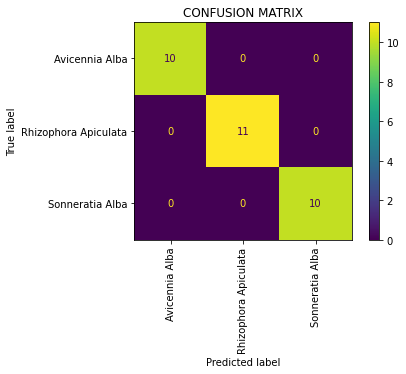

In [77]:
computeMetrics(torch.max(resnet_preds,1).indices,labels)

In [81]:
start = time.time()
data_loaders,vgg_model = trainModel(10,64,0.001640,"vgg16") #20,48,0.5,256,0.001640
end = time.time()

print(f"execution time {end-start}")

epoch: 1 training loss 0.3320190356327937, training accuracy 0.11057692307692309
epoch: 1 training loss 0.6799927124610314, training accuracy 0.22596153846153846
epoch: 1 training loss 1.0097435070918157, training accuracy 0.34615384615384615
epoch: 1 training loss 1.0917008381623488, training accuracy 0.38461538461538464
epoch: 1 validation loss 0.8731637001037598, validation accuracy 0.8524590163934427
epoch: 2 training loss 0.2702599305372972, training accuracy 0.22115384615384617
epoch: 2 training loss 0.5312633697803204, training accuracy 0.4278846153846154
epoch: 2 training loss 0.7691033620100755, training accuracy 0.6538461538461539
epoch: 2 training loss 0.8263238301643958, training accuracy 0.7115384615384616
epoch: 2 validation loss 0.6443255543708801, validation accuracy 0.7377049180327869
epoch: 3 training loss 0.17925711778494027, training accuracy 0.2692307692307693
epoch: 3 training loss 0.32780354756575364, training accuracy 0.5288461538461539
epoch: 3 training loss 0.

CLASSIFICATION REPORT
                      precision    recall  f1-score   support

      Avicennia Alba       1.00      1.00      1.00        10
Rhizophora Apiculata       1.00      1.00      1.00        11
     Sonneratia Alba       1.00      1.00      1.00        10

            accuracy                           1.00        31
           macro avg       1.00      1.00      1.00        31
        weighted avg       1.00      1.00      1.00        31

TEST ACCURACY: 100.0


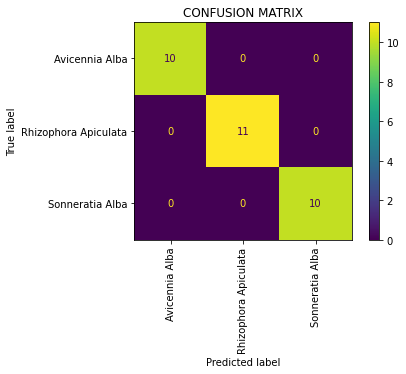

In [82]:
vgg_preds,labels = testModel(vgg_model)
computeMetrics(torch.max(vgg_preds,1).indices,labels)

In [88]:
start = time.time()
data_loaders,alexnet_model = trainModel(10,64,0.001640,"alexnet") #20,48,0.5,256,0.001640
end = time.time()

print(f"execution time {end-start}")

epoch: 1 training loss 0.36458550966702974, training accuracy 0.10096153846153846
epoch: 1 training loss 0.7339538427499624, training accuracy 0.23076923076923078
epoch: 1 training loss 1.05293582035945, training accuracy 0.3605769230769231
epoch: 1 training loss 1.122658371925354, training accuracy 0.40384615384615385
epoch: 1 validation loss 0.8366422057151794, validation accuracy 0.639344262295082
epoch: 2 training loss 0.234633574118981, training accuracy 0.21634615384615385
epoch: 2 training loss 0.42851658967825085, training accuracy 0.46153846153846156
epoch: 2 training loss 0.6087687382331262, training accuracy 0.6971153846153847
epoch: 2 training loss 0.6607327231994042, training accuracy 0.7548076923076924
epoch: 2 validation loss 0.6644918322563171, validation accuracy 0.7049180327868853
epoch: 3 training loss 0.1648685381962703, training accuracy 0.2451923076923077
epoch: 3 training loss 0.3551310942723201, training accuracy 0.4759615384615385
epoch: 3 training loss 0.53497

CLASSIFICATION REPORT
                      precision    recall  f1-score   support

      Avicennia Alba       0.77      1.00      0.87        10
Rhizophora Apiculata       0.71      0.91      0.80        11
     Sonneratia Alba       1.00      0.40      0.57        10

            accuracy                           0.77        31
           macro avg       0.83      0.77      0.75        31
        weighted avg       0.82      0.77      0.75        31

TEST ACCURACY: 77.41935483870968


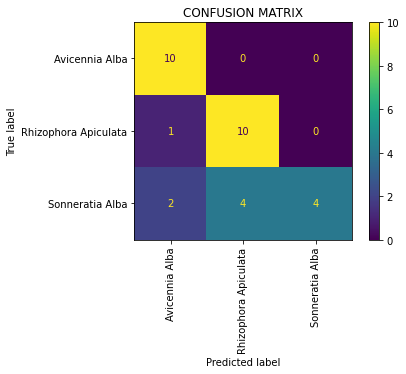

In [89]:
alexnet_preds,labels = testModel(alexnet_model)
computeMetrics(torch.max(alexnet_preds,1).indices,labels)